# Exercise: beam bending with the collocation method

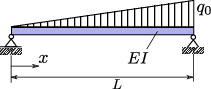

The differential equation for beam bending
$$
(EI w'')'' - q = 0
$$
can be integrated analytically by specifying the linear loading as $q = q_0\frac{x}{L}$ and the boundary conditions
$$
w(0) = 0\\
w(L) = 0\\
w''(0)=0\\
w''(L) = 0
$$
to yield the deflection solution ("Biegelinie"):
$$
w(x) = \frac{q_0 L^4}{360 EI} \left[ 3\left(\frac{x}{L}\right)^5 - 10 \left(\frac{x}{L}\right)^3 + 7 \left(\frac{x}{L}\right)\right]
$$
We now seek to approximate this solution numerically using the collocation method.

In [22]:
import numpy as np #numerical methods
import sympy as sp #symbolic operations
import matplotlib.pyplot as plt #plotting
sp.init_printing(use_latex='mathjax') #makes sympy output look nice

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (8, 6)

In [23]:

#Defining the geometric an material characteristics as symbolic quantities
L,q,EI,x = sp.symbols('L q_0 EI x')

In [24]:
#Analytical solution to deflection
def deflection_analytical():
    a = x/L
    f = q*L**4/(360 * EI)
    return f*(3*a**5 - 10*a**3 + 7*a)

In [25]:
deflection_analytical() #check definition

      ⎛          3      5⎞
 4    ⎜7⋅x   10⋅x    3⋅x ⎟
L ⋅q₀⋅⎜─── - ───── + ────⎟
      ⎜ L       3      5 ⎟
      ⎝        L      L  ⎠
──────────────────────────
          360⋅EI          

Now, let's plot the analytical solution. For that purpose, we use some Python magic ("lambdify"). We sample the analytical solution for $x \in [0,L]$ at 100 points and plot the dimensionless deflection over the dimensionless length.

Text(0,0.5,'$w / L^4 q_0  EI^{-1}$')

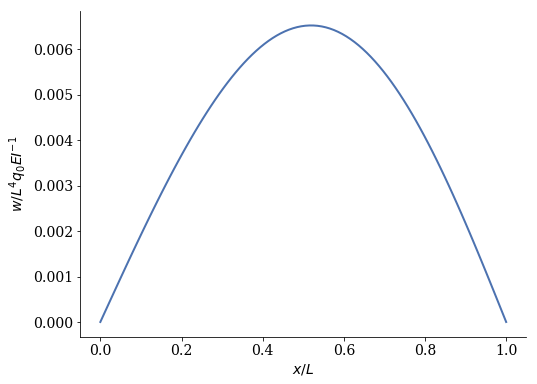

In [26]:
lam_x = sp.lambdify(x, deflection_analytical(), modules=['numpy'])
#For the variable x the function deflection_analytical() will obtain something

x_vals = np.linspace(0, 1, 100)*L #This something is x from 0 to L
analytical = lam_x(x_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical

plt.plot(x_vals/L, analytical/(L**4*q)*EI)
plt.xlabel('$x / L$')
plt.ylabel('$w / L^4 q_0  EI^{-1}$')

## Trigonometric Ansatz

Let's try the approximation
$$
    \tilde{w} = a_1 \sin \left(\pi \frac{x}{L}\right) + a_2 \sin \left(2\pi\frac{x}{L}\right)
$$

In [27]:
a1, a2 = sp.symbols('a_1 a_2')#Defining the free values as new symbols

In [28]:
def deflection_ansatz():
    return a1*sp.sin(sp.pi/L*x) + a2*sp.sin(2*sp.pi/L*x) #defining the approximate solution with the unknown coefficients

Now we substitute this solution into the fourth-order ODE for beam bending by differentiating it twice and adding the distributed loading:
$$
EI w^\text{IV} - q_0 \frac{x}{L} = 0 \text{ with } EI = \text{const.}
$$

In [29]:
ODE = EI * deflection_ansatz().diff(x,4) - q * (x/L)
ODE

 4    ⎛      ⎛π⋅x⎞            ⎛2⋅π⋅x⎞⎞       
π ⋅EI⋅⎜a₁⋅sin⎜───⎟ + 16⋅a₂⋅sin⎜─────⎟⎟       
      ⎝      ⎝ L ⎠            ⎝  L  ⎠⎠   q₀⋅x
────────────────────────────────────── - ────
                   4                      L  
                  L                          

Now we evaluate the Ansatz we made at two collocation points distributed along the beam: $x_1 = L/2$ and $x_2 = 3L/4$. This creates two equations for two unknowns:

In [30]:
collocation_conditions = (ODE.subs(x,L/4), ODE.subs(x,3*L/4))

In [31]:
collocation_conditions

⎛ 4    ⎛√2⋅a₁        ⎞        4    ⎛√2⋅a₁        ⎞       ⎞
⎜π ⋅EI⋅⎜───── + 16⋅a₂⎟       π ⋅EI⋅⎜───── - 16⋅a₂⎟       ⎟
⎜      ⎝  2          ⎠   q₀        ⎝  2          ⎠   3⋅q₀⎟
⎜───────────────────── - ──, ───────────────────── - ────⎟
⎜           4            4              4             4  ⎟
⎝          L                           L                 ⎠

Now we solve these equations for our values $a_1$ and $a_2$ by demanding that the residuals vanish at the collocation points:

In [32]:
coefficients = sp.solve(collocation_conditions,a1,a2)

In [33]:
coefficients

⎧        4           4     ⎫
⎪    √2⋅L ⋅q₀      -L ⋅q₀  ⎪
⎨a₁: ────────, a₂: ────────⎬
⎪       4              4   ⎪
⎩    2⋅π ⋅EI       64⋅π ⋅EI⎭

Now we're ready to plot the result and compare it to the analytical solution. 

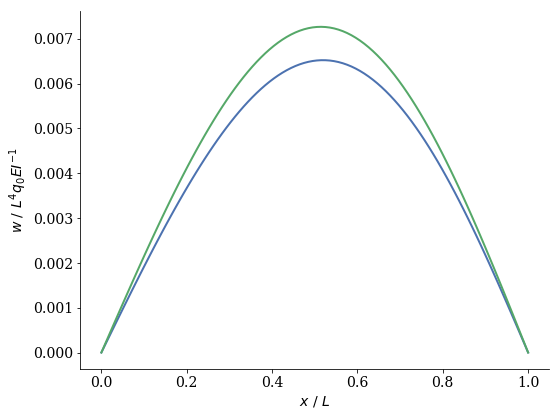

In [34]:
#We first substite the now known Ansatz free values into our Ansatz
z = sp.symbols('z')
w_numerical = deflection_ansatz().subs([(a1,coefficients[a1]),(a2,coefficients[a2]),(x,z*L)])
#We also made the coordinate dimensionless (x/L --> z) because of sympy problems

lam_x_num = sp.lambdify(z, w_numerical, modules=['numpy'])
#For the variable x the expression w_numerical will be given something
z_vals = np.linspace(0, 1,100) #This something is z from 0 to 1
numerical = lam_x_num(z_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical
plt.plot(x_vals/L, analytical/(L**4*q)*EI)
plt.plot(z_vals, numerical/(L**4*q)*EI)
plt.xlabel('$x\ /\ L$')
plt.ylabel('$w\ /\ L^4 q_0  EI^{-1}$')
plt.tight_layout()

In [35]:
print("Maximum absolute error in deflection: ", np.max(np.abs(analytical/(L**4*q)*EI - numerical/(L**4*q)*EI)))

Maximum absolute error in deflection:  0.000751049425655786


We can also plot and compare the bending moment. Let's first find the analytical expression by symbolically differentiating the deflection expression twice to obtain $M(x) = -EI w''(x)$:

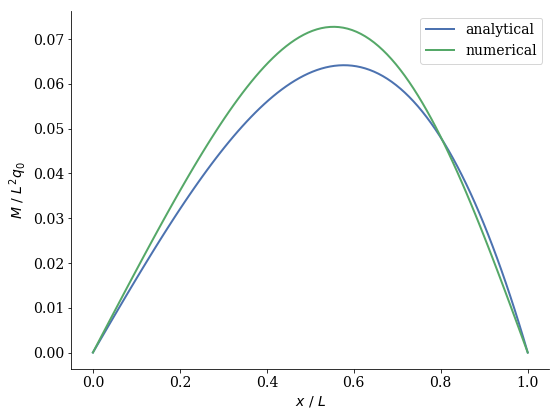

In [36]:
#analytical bending moment
moment_analytical = -deflection_analytical().diff(x,2)*EI
#numerical bending moment
moment_numerical = -deflection_ansatz().subs([(a1,coefficients[a1]),(a2,coefficients[a2])]).diff(x,2)*EI

#create lambdas for plotting along dimensionless length z
lam_x_analyt = sp.lambdify(z, moment_analytical.subs(x,z*L), modules=['numpy'])
lam_x_num = sp.lambdify(z, moment_numerical.subs(x,z*L), modules=['numpy'])
z_vals = np.linspace(0, 1,100)
analytical = lam_x_analyt(z_vals)
numerical = lam_x_num(z_vals)

#plot
plt.plot(x_vals/L, analytical/(L**2*q),label='analytical')
plt.plot(z_vals, numerical/(L**2*q),label='numerical')
plt.xlabel('$x\ /\ L$')
plt.ylabel('$M\ /\ L^2 q_0$')
plt.legend()
plt.tight_layout()
plt.savefig('beam_collocation_moment.pdf')

In [37]:
print("Maximum absolute error in bending moment: ", np.max(np.abs(analytical/(L**2*q) - numerical/(L**2*q))))

Maximum absolute error in bending moment:  0.00915175157530091


*Tasks*:

- What happens if you chose the symmetrical collocation points $L/4$ and $3L/4$?
- What happens if you move them further outside or inside?
- How does the solution develop when you choose the Ansatz $\tilde{w} = a_1 \left(\frac{x}{L}\right)^4 + a_2 \left(\frac{x}{L}\right)^6$? Why is the result so bad? (Hint: Ansatz requirements)
- How does the solution develop, if you add another member of the same shape, e.g. $a_3 \sin\left(\pi\frac{x}{L}\right)  $ but add another collocation point? (Hint: Ansatz requirements)